In [129]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

#os.chdir("../../..")

In [130]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd

In [131]:
#!pip install pyarrow

In [132]:
fix_seed = 2021
import random
import torch
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [133]:
# #from pytorch_forecasting.data.examples import get_stallion_data

# # compare with previous study
# #data = pd.read_csv("/Users/xul2/Desktop/CMU/Research/Covid 19/previous.csv")

# # validation & forecasting 7 day ahead
# data = pd.read_csv("/Users/xul2/Desktop/CMU/Research/Covid 19/7-Day Average.csv")

In [134]:
#from pytorch_forecasting.data.examples import get_stallion_data
data = pd.read_csv("brazil_patch.csv")
data = data.drop(columns=['Unnamed: 0','date','Gathering','Transport'])
cols = data.columns.tolist()
cols = cols[-1:]+cols[:-1]
k3 =data[cols]

In [135]:
k3.columns

Index(['new_cases_smoothed', 'stringency_index', 'face_coverings',
       'Stay_home'],
      dtype='object')

In [136]:
# from pandas import read_csv
# from matplotlib import pyplot
# # load dataset
# dataset = data
# values = dataset.values


In [137]:
# # Choose Country
# data_interest = data.loc[data["Country"] == "India"]
# # state  = data_wa["state"].iloc[1]
# data_interest

In [138]:
# # validate
# #data_clear = data_interest.drop(columns = ["Date","Country","Cumulative","Cases","TRUE","7-day"])

# # previous 
# #data_clear = data_interest.drop(columns = ["Deaths", "Date","Confirmed","Recovered","TRUE","Confirmed","Country","7-day"])

# # forecast
# data_clear = data_interest.drop(columns = ["Date","Country","Cumulative","Cases","TRUE","7-day"])
# data_clear

In [139]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# This has been taken from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/  
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = k3
values = dataset.values 
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed)

     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1     0.457580   0.619589        1.0   0.666667  0.453621
2     0.453621   0.619589        1.0   0.666667  0.452851
3     0.452851   0.619589        1.0   0.666667  0.448496
4     0.448496   0.619589        1.0   0.666667  0.451605
5     0.451605   0.619589        1.0   0.666667  0.464148
..         ...        ...        ...        ...       ...
361   0.054498   0.531754        0.0   0.333333  0.064156
362   0.064156   0.531754        0.0   0.333333  0.076024
363   0.076024   0.531754        0.0   0.333333  0.092085
364   0.092085   0.531754        0.0   0.333333  0.103908
365   0.103908   0.531754        0.0   0.333333  0.104104

[365 rows x 5 columns]


In [140]:
# split into train and test sets

values = reframed.values

# evalidate 
# train = values[:194,:]
# forecasting = values[193:194]

# forecast 7 day ahead
train = values[:292,:]
forecasting = values[364:365]

# previous
# train = values[:130,:]
# forecasting = values[129:130]

# spli\t into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
forecast_X = forecasting[:, :-1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
forecast_X = forecast_X.reshape((forecast_X.shape[0], 1, forecast_X.shape[1]))
print(train_X.shape, train_y.shape, forecast_X.shape)

(292, 1, 4) (292,) (1, 1, 4)


In [141]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [143]:
from torch.utils.data import Dataset

# for training
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

dataset_train = timeseries(train_X,train_y)
#dataloader
from torch.utils.data import DataLoader 
train_loader = DataLoader(dataset_train,shuffle=False,batch_size=400)

In [144]:
# for forecasting
class forecast(Dataset):
    def __init__(self,x):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx]
  
    def __len__(self):
        return self.len


dataset_forecast = forecast(forecast_X)
#dataloader
from torch.utils.data import DataLoader 
forecast_loader = DataLoader(dataset_forecast,shuffle=False,batch_size=1)

In [145]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        # CNN architechtures
        self.ch1, self.ch2, self.ch3 = 32, 45, 64
        #self.ch1, self.ch2, self.ch3 = 32, 64, 128
        self.outputDim = 1
        
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=self.ch1,kernel_size=2)#5 
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=self.ch1,out_channels=self.ch2,kernel_size=2)#4
        self.conv3 = nn.Conv1d(in_channels=self.ch2,out_channels=self.ch3,kernel_size=2)#3
        self.fc1 = nn.Linear(self.ch3,120)
        self.fc2 = nn.Linear(120,self.outputDim)
        
    def forward(self,x):
        #print(x.shape)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)  
        x = self.relu(x)
        x = self.conv3(x)  
        x = self.relu(x)
        #print(x.shape)
        x = x.view(-1,self.ch3) # flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)     
        return x

In [146]:
num_epochs = 300
learning_rate = 0.005

cnn = CNN_ForecastNet()
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [147]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device  = torch.device('cpu')

In [148]:
training_loss = []
for epoch in range(num_epochs):
    cnn.train()
    cnn.to(device)
    print('Epoch_Number: ', epoch)
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
     
        outputs = cnn(data)

        loss = criterion(outputs, target.reshape(-1,1))

        running_loss += loss.item()
        loss.backward()
        optimizer.step()   
    running_loss /= len(train_loader)
    training_loss.append(running_loss)
    print('Training Loss: ', running_loss)

Epoch_Number:  0
Training Loss:  0.5146035552024841
Epoch_Number:  1
Training Loss:  0.322969913482666
Epoch_Number:  2
Training Loss:  0.16467967629432678
Epoch_Number:  3
Training Loss:  0.05033954977989197
Epoch_Number:  4
Training Loss:  0.09360931813716888
Epoch_Number:  5
Training Loss:  0.12130498141050339
Epoch_Number:  6
Training Loss:  0.06664679944515228
Epoch_Number:  7
Training Loss:  0.03646344318985939
Epoch_Number:  8
Training Loss:  0.04044635221362114
Epoch_Number:  9
Training Loss:  0.05428972467780113
Epoch_Number:  10
Training Loss:  0.06312011182308197
Epoch_Number:  11
Training Loss:  0.06286238133907318
Epoch_Number:  12
Training Loss:  0.05499441921710968
Epoch_Number:  13
Training Loss:  0.04319872334599495
Epoch_Number:  14
Training Loss:  0.03253256902098656
Epoch_Number:  15
Training Loss:  0.02772338315844536
Epoch_Number:  16
Training Loss:  0.030783280730247498
Epoch_Number:  17
Training Loss:  0.03662317246198654
Epoch_Number:  18
Training Loss:  0.0370

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(-50.0, 0, '−50'),
  Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300'),
  Text(350.0, 0, '350')])

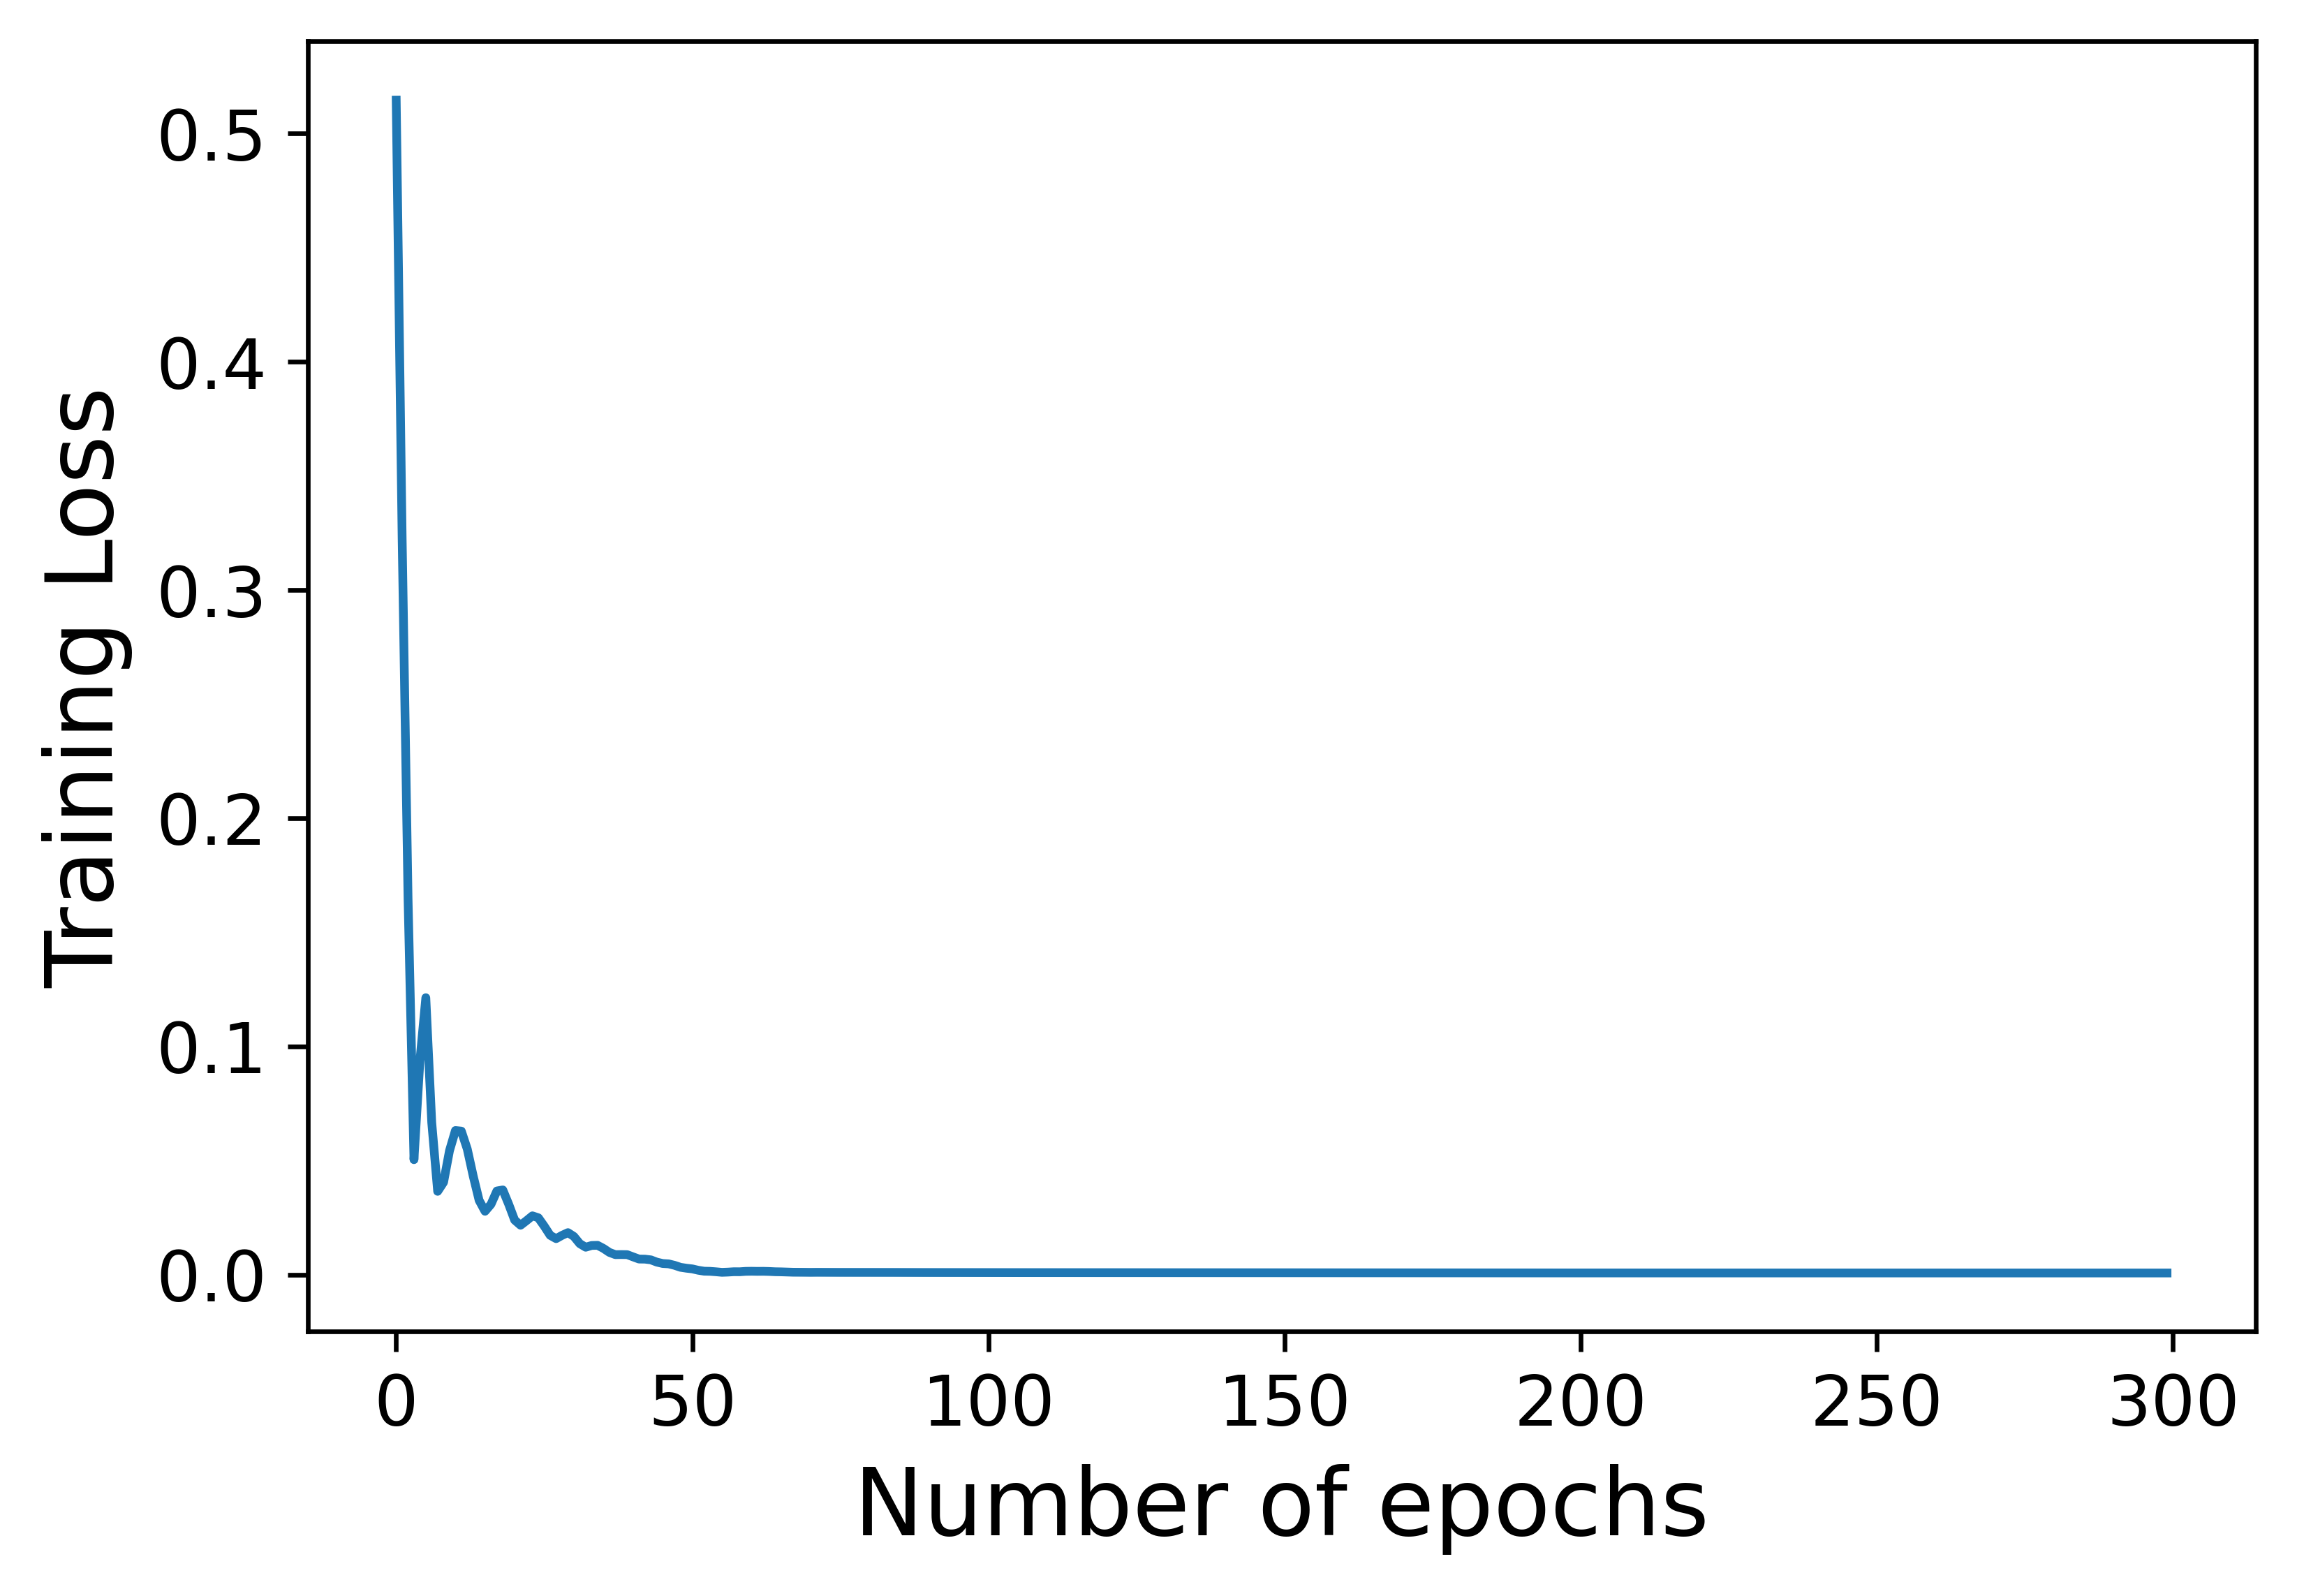

In [149]:
fig = plt.figure(figsize = [6,4], dpi = 600)
width = 2
tick_width = 1.5
ax = plt.gca()
plt.plot(training_loss)
plt.xlabel('Number of epochs',fontsize=16)
plt.ylabel('Training Loss',fontsize=16)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
#plt.xlim([0,0.05])
# df = pd.DataFrame(training_loss)
# df.to_csv('loss_russia_cnn.csv',index = False, header = False)

In [150]:
predict = []
# 8: forecast
# 18: previous
# 19: evalidate
for predict_day in range(4):
    out = []  
    cnn.eval()
    cnn.to(device)

    for data in forecast_loader:

        data = data.to(device)
        outputs = cnn(data)
        out.append(outputs)

    out_cat = torch.cat(out)
    out_cp = out_cat.cpu().detach().numpy()

    policy = forecasting[:, 1:-1]
    pre_X = np.concatenate((out_cp,policy), axis = 1)
    pre_X = pre_X.reshape((pre_X.shape[0], 1, pre_X.shape[1]))
    dataset_forecast = forecast(pre_X)
    forecast_loader = DataLoader(dataset_forecast,shuffle=False,batch_size=1)
    predict.append(out_cp)


In [151]:
predict

[array([[0.36162576]], dtype=float32),
 array([[0.43875277]], dtype=float32),
 array([[0.4642587]], dtype=float32),
 array([[0.46838441]], dtype=float32)]

In [152]:
outputs = []
forecast_X = forecast_X.reshape((forecast_X.shape[0], forecast_X.shape[2]))
for i in range(len(predict)):      
    inv_yhat = concatenate((predict[i], forecast_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    outputs.append(inv_yhat)

In [153]:
outputs

[array([28446.672], dtype=float32),
 array([34513.734], dtype=float32),
 array([36520.117], dtype=float32),
 array([36844.66], dtype=float32)]

In [154]:
#from pytorch_forecasting.data.examples import get_stallion_data
data = pd.read_csv("/home/mail12/Nerf-diffusion/covid_19/FINAL/TRANSFORMER/forecast_brazil.csv")
#data
data = data.drop(columns=['Unnamed: 0'])

In [155]:
cols = data.columns.tolist()
cols = cols[-1:]+cols[:-1]
cols = ['new_cases_smoothed', 'stringency_index', 'face_coverings', 'Gathering',
       'Transport', 'Stay_home']


In [156]:
k3 =data[cols]

In [157]:
# validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
#d = pd.read_csv("/home/mail12/Nerf-diffusion/covid_19/FINAL/TRANSFORMER/forecast_russia.csv")
#d_interest = d.loc[d["Country"] == "Russia"]
y = k3['new_cases_smoothed'].values[11:15]
y_pre = outputs#[1:-1]
rmse = sqrt(mean_squared_error(y, y_pre))
mae = mean_absolute_error(y,y_pre)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 24760.850
Test MAE: 24649.903


In [158]:
folder_path = '/home/mail12/Nerf-diffusion/covid_19/FINAL/CNN/'
np.save(folder_path + 'brazil_metrics.npy', np.array([mae, rmse]))
np.save(folder_path + 'brazil_results.npy', np.array([y, y_pre]))

In [159]:
# Cumulative cases calculation
# d = pd.read_csv("/Users/xul2/Desktop/CMU/Research/Covid 19/7-Day Average.csv")
# d_interest = d.loc[d["Country"] == "Russia"]
# y = d_interest["Cumulative"].values[194:212]
# # y = d_interest["Confirmed"].values[131:148]
# print(y)
# y_pre = []
# # Brazil
# b = 19151993
# # India
# b = 30946147
# # Russia
# b = 5762211
# for i in range(len(outputs)-1):
#     b = b+outputs[i+1]
#     y_pre.append(b)
# df = pd.DataFrame(y_pre)
# df.to_csv('cnn_russia_pre.csv',index = False, header = False)

In [160]:
# Compare with previous study
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score
# from sklearn.metrics import explained_variance_score
# d = pd.read_csv("/Users/xul2/Desktop/CMU/Research/Covid 19/previous.csv")
# d_interest = d.loc[d["Country"] == "France"]
# y = d_interest["Confirmed"].values[131:148]
# print(y)
# y_pre = []
# # Italy
# #b = 232997
# # # Spain
# b = 239479
# # # France
# b = 190975
# # # US
# # b = 1798718

# for i in range(len(outputs)-1):
#     b = b+outputs[i+1]
#     y_pre.append(b)
# rmse = sqrt(mean_squared_error(y, y_pre))
# mae = mean_absolute_error(y,y_pre)
# print('Test RMSE: %.3f' % rmse)
# print('Test MAE: %.3f' % mae)
    